In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from scipy.optimize import minimize

In [15]:
aapl = pd.read_csv('AAPL.csv', index_col='Date', parse_dates=True)

In [16]:
aapl = aapl.drop(['Open', 'High','Low','Close','Volume'], axis=1)

In [17]:
amzn = pd.read_csv('AMZN.csv', index_col='Date', parse_dates=True)

In [18]:
amzn = amzn.drop(['Open', 'High','Low','Close','Volume'], axis=1)

In [19]:
csco = pd.read_csv('CSCO.csv', index_col='Date', parse_dates=True)

In [20]:
csco = csco.drop(['Open', 'High','Low','Close','Volume'], axis=1)

In [21]:
ibm = pd.read_csv('IBM.csv', index_col='Date', parse_dates=True)

In [22]:
ibm = ibm.drop(['Open', 'High','Low','Close','Volume'], axis=1)

In [23]:
stocks=pd.concat([aapl,csco,ibm,amzn], axis=1)

In [24]:
stocks.columns = ['aapl','csco','ibm','amzn']

In [25]:
stocks

,aapl,csco,ibm,amzn
Date,,,,
2016-11-10,25.365192,26.532455,121.781776,742.380005
2016-11-11,25.515797,26.840570,122.579872,739.010010
2016-11-14,24.875729,26.849136,120.254013,719.070007
2016-11-15,25.205173,27.131577,120.603638,743.239990
2016-11-16,25.882893,27.020309,121.074928,746.489990
...,...,...,...,...
2021-11-03,151.269241,57.650002,119.938713,3384.000000
2021-11-04,150.740005,57.119999,119.258591,3477.000000
2021-11-05,151.279999,57.070000,121.982246,3518.989990


In [29]:
log_ret = np.log(stocks/stocks.shift(1))
log_ret

,aapl,csco,ibm,amzn
Date,,,,
2016-11-10,NaN,NaN,NaN,NaN
2016-11-11,0.005920,0.011546,0.006532,-0.004550
2016-11-14,-0.025405,0.000319,-0.019157,-0.027353
2016-11-15,0.013157,0.010465,0.002903,0.033060
2016-11-16,0.026533,-0.004109,0.003900,0.004363
...,...,...,...,...
2021-11-03,0.009751,0.000521,0.007501,0.021280
2021-11-04,-0.003505,-0.009236,-0.005687,0.027111
2021-11-05,0.003576,-0.000876,0.022581,0.012004


In [30]:

np.random.seed(42)
num_ports = 6000
all_weights = np.zeros((num_ports, len(stocks.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for x in range(num_ports):
    # Weights
    weights = np.array(np.random.random(4))
    weights = weights/np.sum(weights)
    
    # Save weights
    all_weights[x,:] = weights
    
    # Expected return
    ret_arr[x] = np.sum( (log_ret.mean() * weights * 252))
    
    # Expected volatility
    vol_arr[x] = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov()*252, weights)))
    
    # Sharpe Ratio
    sharpe_arr[x] = ret_arr[x]/vol_arr[x]


In [31]:
print("Max sharpe ratio in the array : {}".format(sharpe_arr.max()))
print("Its location in the array : {}".format(sharpe_arr.argmax()))


Max sharpe ratio in the array : 1.2503543806760384
Its location in the array : 5597


In [32]:
print(all_weights[5597,:])

max_sr_ret = ret_arr[sharpe_arr.argmax()]

max_sr_vol = vol_arr[sharpe_arr.argmax()]

[0.64285834 0.00746897 0.00393976 0.34573293]


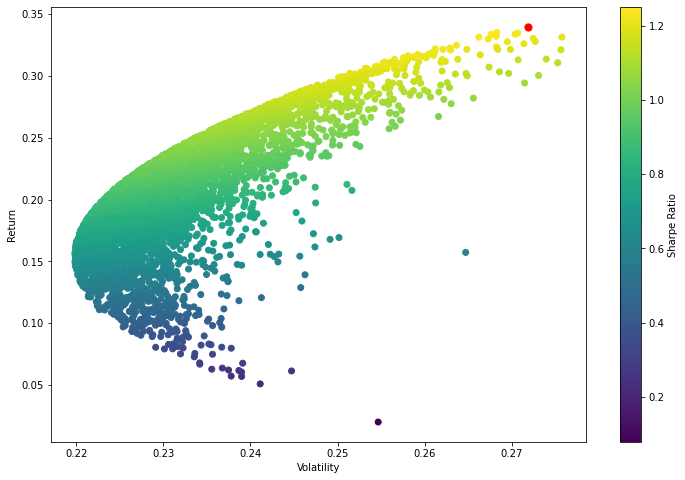

In [35]:

plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.scatter(max_sr_vol, max_sr_ret,c='red', s=50) # red dot
plt.show()


In [36]:
def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum(log_ret.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov()*252, weights)))
    sr = ret/vol
    return np.array([ret, vol, sr])

def neg_sharpe(weights):
# the number 2 is the sharpe ratio index from the get_ret_vol_sr
    return get_ret_vol_sr(weights)[2] * -1

def check_sum(weights):
    #return 0 if sum of the weights is 1
    return np.sum(weights)-1

In [37]:
cons = ({'type':'eq','fun':check_sum})
bounds = ((0,1),(0,1),(0,1),(0,1))
init_guess = [0.25,0.25,0.25,0.25]

In [42]:
opt_results = minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
print(opt_results)

     fun: -1.2552683160404123
     jac: array([-1.79633498e-04,  1.67641491e-01,  5.45947880e-01,  2.66864896e-04])
 message: 'Optimization terminated successfully'
    nfev: 20
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.59770112, 0.        , 0.        , 0.40229888])


In [44]:
get_ret_vol_sr(opt_results.x)

array([0.34040714, 0.27118277, 1.25526832])

In [48]:
frontier_y = np.linspace(0,0.3,200)

In [49]:
def minimize_volatility(weights):
    return get_ret_vol_sr(weights)[1]

In [50]:
frontier_x = []

for possible_return in frontier_y:
    cons = ({'type':'eq', 'fun':check_sum},
            {'type':'eq', 'fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
    
    result = minimize(minimize_volatility,init_guess,method='SLSQP', bounds=bounds, constraints=cons)
    frontier_x.append(result['fun'])

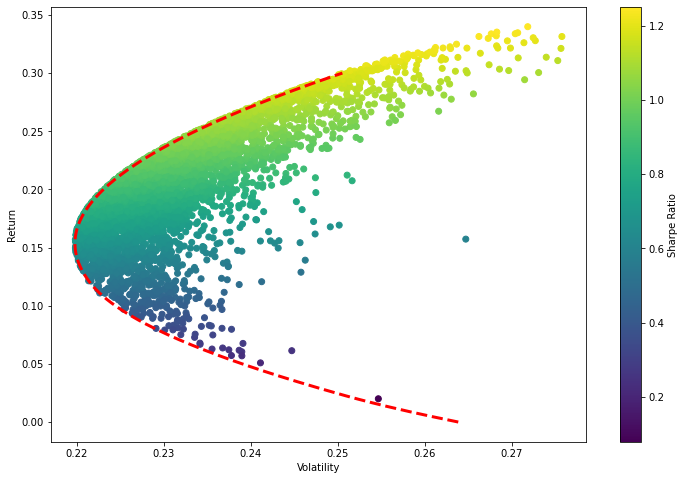

In [51]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.plot(frontier_x,frontier_y, 'r--', linewidth=3)
plt.savefig('cover.png')
plt.show()